#Time-series forecasting with deep learning & LSTM autoencoders

- forecast the total amount of products sold in every shop

- the list of shops and products slightly changes every month.

https://www.kaggle.com/code/dimitreoliveira/time-series-forecasting-with-lstm-autoencoders

#Mount to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Dependencies

In [ ]:
import os, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras import optimizers, Sequential, Model

def seed_everything(seed=0):
    #for any random number generation using Python built-in random module
    random.seed(seed)
    np.random.seed(seed)
    #for any random operations within TensorFlow
    tf.random.set_seed(seed)
    #for hash-based operations in various internal operations
    os.environ['PYTHONHASHSEED'] = str(seed)
    #1: TensorFlow use deterministic operations(produce consistent results give the same inputs) when possible
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')
#formats floating-point numbers to have two decimal places when they are displayes in pandas DataFrames.
pd.set_option('display.float_format', lambda x: '%.2f' % x)

#Loading Data

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/KUCC/23-2 캐글 필사 스터디/test.csv',
                   dtype = {'ID': 'int32', 'shop_id': 'int32', 'item_id': 'int32'})
item_categories = pd.read_csv('/content/drive/MyDrive/KUCC/23-2 캐글 필사 스터디/item_categories.csv',
                              dtype = {'item_cagegory_name': 'str', 'item_category_id': 'int32'})
items = pd.read_csv('/content/drive/MyDrive/KUCC/23-2 캐글 필사 스터디/items.csv',
                    dtype = {'item_name': 'str', 'item_id': 'int32', 'item_category_id': 'int32'})
shops = pd.read_csv('/content/drive/MyDrive/KUCC/23-2 캐글 필사 스터디/shops.csv',
                    dtype = {'shop_name': 'str', 'shop_id': 'int32'})
sales = pd.read_csv('/content/drive/MyDrive/KUCC/23-2 캐글 필사 스터디/sales_train.csv', parse_dates=['date'],
                    dtype = {'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32',
                             'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})
#parse_dates=['date']: date column should be parsed as datetime objects

In [ ]:
print('sales >', sales.head(1))
print('items >', items.head(1))
print('shops >', shops.head(1))
print('item_categories >', item_categories.head(1))

sales >         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0 2013-02-01               0       59    22154      999.00             1
items >                                    item_name  item_id  item_category_id
0  ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0                40
shops >                        shop_name  shop_id
0  !Якутск Орджоникидзе, 56 фран        0
item_categories >         item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0


#Join Data sets

In [ ]:
#on을 기준으로 join.
#rsuffix: handle situations where there are overlapping column names
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

#Let's take a look at the raw data

In [ ]:
print(f'Train rows: {train.shape[0]}')
print(f'Train columns: {train.shape[1]}')

display(train.head().T)
print('\n')
display(train.describe())

Train rows: 2935849
Train columns: 10


,0,1,2,3,4
date,2013-02-01 00:00:00,2013-03-01 00:00:00,2013-05-01 00:00:00,2013-06-01 00:00:00,2013-01-15 00:00:00
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999.00,899.00,899.00,1709.05,1099.00
item_cnt_day,1,1,-1,1,1
item_name,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE Who Do You Think We Are LP,DEEP PURPLE 30 Very Best Of 2CD (Фирм.)
item_category_id,37,58,58,58,56
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
item_category_name,Кино - Blu-Ray,Музыка - Винил,Музыка - Винил,Музыка - Винил,Музыка - CD фирменного производства


,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.85,1.24,40.00
std,9.42,16.23,6324.30,1729.80,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


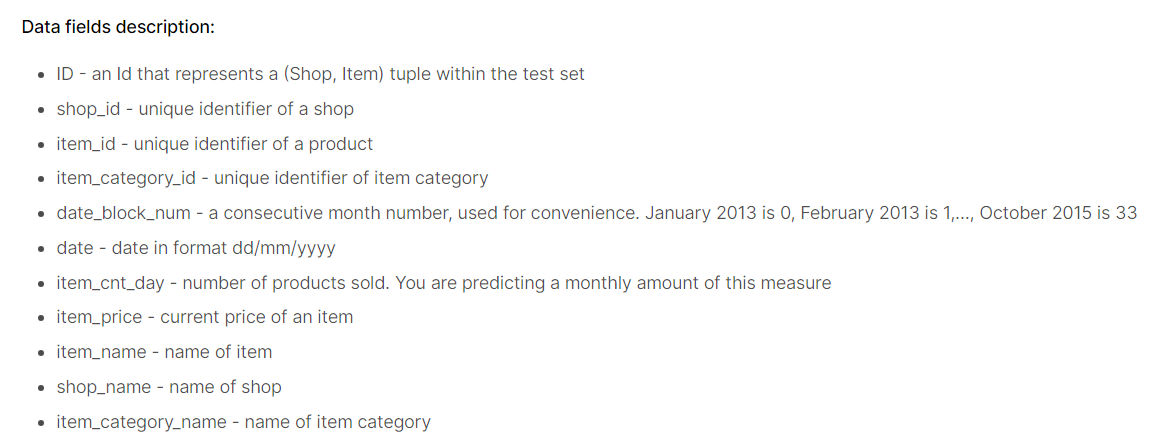

#Time period of the dataset

In [ ]:
print(train['date'].min())
print(train['date'].min().date())

2013-01-01 00:00:00
2013-01-01


In [ ]:
print(f"Min date from train set: {train['date'].min().date()}")
print(f"Max date from train set: {train['date'].max().date()}")

Min date from train set: 2013-01-01
Max date from train set: 2015-12-10


#leaving only the 'shop_id' and 'item_id' that exist in the test set

In [ ]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
train = train[train['shop_id'].isin(test_shop_ids)]
train = train[train['item_id'].isin(test_item_ids)]

#Data Preprocessing

In [ ]:
train.head(1)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,2013-02-01,0,59,22154,999.00,1,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray


In [ ]:
train_monthly = train[['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]

#as_index=False: 그룹화된 열이 인덱스로 설정되지 않음. 열로 남아있음.
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_cnt_day': ['sum']})
train_monthly.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt']
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20')
train_monthly

,date_block_num,shop_id,item_id,item_cnt
0,0,2,33,1
1,0,2,482,1
2,0,2,491,1
3,0,2,839,1
4,0,2,1007,3
...,...,...,...,...
600154,33,59,22087,6
600155,33,59,22088,2
600156,33,59,22091,1
600157,33,59,22100,1


In [ ]:
#shift the 'item_cnt' values one step ahead within each group defined by 'shop_id' and 'item_id'
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

display(train_monthly.head(10).T)
display(train_monthly.describe().T)

,0,1,2,3,4,5,6,7,8,9
date_block_num,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
shop_id,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00
item_id,33.00,482.00,491.00,839.00,1007.00,1010.00,1023.00,1204.00,1224.00,1247.00
item_cnt,1.00,1.00,1.00,1.00,3.00,1.00,2.00,1.00,1.00,1.00
item_cnt_month,2.00,1.00,1.00,1.00,1.00,1.00,1.00,NaN,NaN,NaN


,count,mean,std,min,25%,50%,75%,max
date_block_num,593829.00,20.18,9.14,0.00,13.00,22.00,28.00,33.00
shop_id,593829.00,32.07,16.90,2.00,19.00,31.00,47.00,59.00
item_id,593829.00,10015.02,6181.82,30.00,4418.00,9171.00,15334.00,22167.00
item_cnt,593829.00,2.10,2.31,0.00,1.00,1.00,2.00,20.00
item_cnt_month,482536.00,2.07,2.17,0.00,1.00,1.00,2.00,20.00


⏩ item_cnt : 현재 월 판매량

⏩ item_cnt_month : 다음 월 판매량 (우리가 예측하고자 하는 것. 반드시 한 달 뒤인 것은 아니고, 존재하는 데이터 기준으로 다음 달 판매량임)

- item_cnt_month가 nan인 것은 데이터프레임에 해당 shop, item 조합이 한 월에 대해서만 존재하기 때문.

#Time-series Processing

In [ ]:
monthly_series = train_monthly.pivot_table(index=['shop_id', 'item_id'], columns='date_block_num',
                                           values='item_cnt', fill_value=0).reset_index()
monthly_series.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,2,30,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,31,0,4,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,32,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,2,33,1,0,0,0,0,0,0,0,...,0,1,0,1,1,0,1,0,1,0
4,2,53,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


shop_id, item_id별로 34개 months로 구성된 하나의 series가 있다. 이제 shop_id, item_id별로 12개 months (1 year)의 크기를 가진 series를 여러 개 만들어보자.

In [ ]:
first_month = 20
last_month = 33
serie_size = 12  #각 series가 포함하는 월 개수
data_series = []

#각 상점, 제품 조합에 대한 시계열 데이터를 생성
for index, row in monthly_series.iterrows():
    for month1 in range((last_month - (first_month + serie_size)) + 1):  #month1: 0, 1 => 각 shop, item 조합에 대해 series가 두 개씩 생성됨
        serie = [row['shop_id'], row['item_id']]
        for month2 in range(serie_size + 1):  #month2: 0,...,12 => 각 shop, item 조합에 대해 13개의 값(1개는 label)이 존재
            serie.append(row[month1 + first_month + month2])  #첫번째 series: month 20부터 month 32(label)까지
                                                              #두번째 series: month 21부터 month 33(label)까지
        data_series.append(serie)

columns = ['shop_id', 'item_id']
[columns.append(i) for i in range(serie_size)]
columns.append('label')

data_series = pd.DataFrame(data_series, columns=columns)
data_series.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,label
0,2,30,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,30,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,31,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,31,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2,32,2,2,0,2,0,0,1,0,0,0,0,1,0


In [ ]:
data_series = data_series.drop(['item_id', 'shop_id'], axis=1)

#Train and Validation

In [ ]:
labels = data_series['label']
data_series.drop('label', axis=1, inplace=True)

train, valid, Y_train, Y_valid = train_test_split(data_series, labels.values, test_size=0.10, random_state=0)

In [ ]:
print('Train set', train.shape)
print('Validation set', valid.shape)
train.head()

Train set (200327, 12)
Validation set (22259, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
207604,0,0,0,0,0,0,0,0,0,0,0,0
45150,0,0,0,0,0,0,0,0,0,0,0,0
143433,0,0,4,2,1,2,2,1,0,0,0,1
202144,0,0,0,0,0,0,0,0,0,0,0,0
136088,0,0,0,0,0,0,0,1,0,0,1,0


#Reshape Data
- (data points, time-steps, features)

In [ ]:
X_train = train.values.reshape((train.shape[0], train.shape[1], 1))
X_valid = valid.values.reshape((valid.shape[0], valid.shape[1], 1))

print('Train set reshaped', X_train.shape)
print('Validation set reshaped', X_valid.shape)

Train set reshaped (200327, 12, 1)
Validation set reshaped (22259, 12, 1)


#Regular LSTM model

**Cell State**

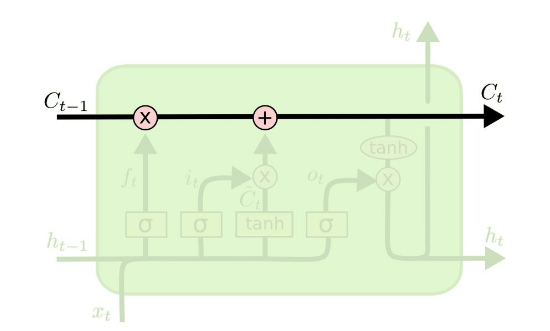
- 핵심 구성 요소.
- linear interaction을 적용해, 정보가 전혀 바뀌지 않고 그대로 흐른다. state가 꽤 오래 경과하더라도 gradient가 잘 전파된다.
- Gate라는 구조에 의해서 정보가 추가 및 제거되며, Gate는 training을 통해 어떤 정보를 유지하고 버릴지 학습한다.

**Step 1: 지금까지의 cell state에 저장된 정보 중에서 얼마만큼을 forget할 것인지 결정**

Forget Gate

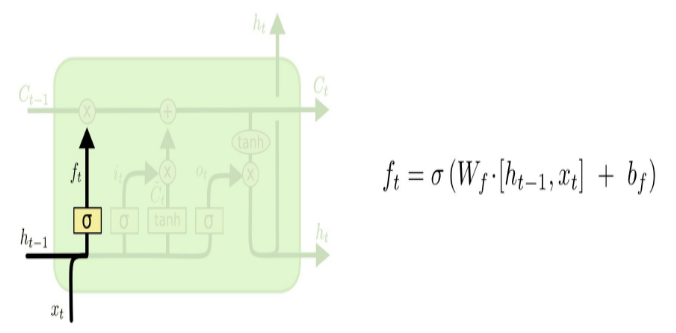

- 이전 단계의 hidden state와 현 단계의 입력으로부터 sigmoid 함수를 통해 0과 1의 값을 출력.
- 1: 지금까지 cell state에 저장된 모든 정보를 보존
- 0: 지금까지 cell state에 저장된 모든 정보를 무시

**Step 2: 새로운 정보를 얼마만큼 cell state에 저장할 것인지를 결정**

Input Gate
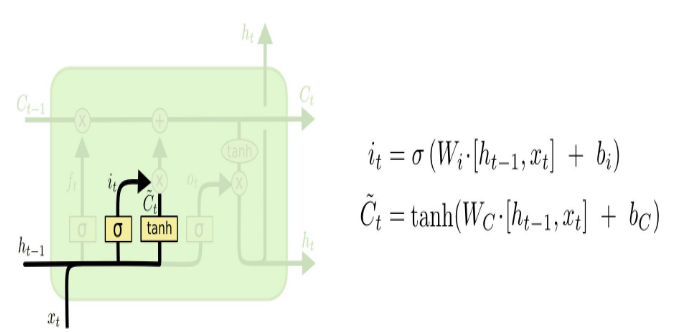

- 어떤 값을 업데이트할 것인지 결정
- tanh layer를 사용하여 새로운 cell state의 후보를 생성

**Step 3: 예전 cell state를 새로운 cell state로 업데이트**

- 예전 cell state를 얼마만큼 잊을 것인가를 계산한 forget gate 결과값과 곱함.
- 새로운 cell state 후보와 얼마만큼 보존할 것인가를 계산한 input gate 결과값을 곱함
- 두 값을 더하여 새로운 cell state 값으로 결정

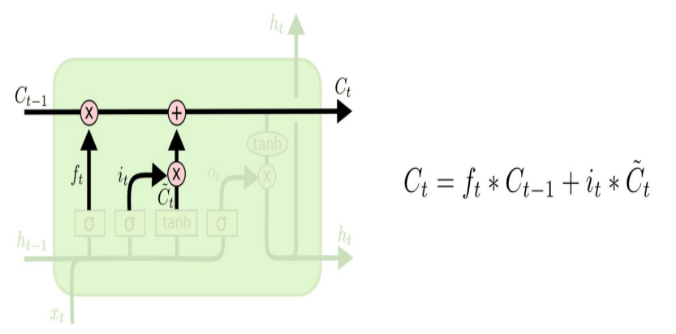

**Step 4: 출력 값을 결정**
- 이전 hidden state 값과 현재의 입력 값을 이용하여 ouput gate 값을 산출
- output gate 값과 현재의 cell state 값을 결합하여 현재의 hidden state 값을 계산

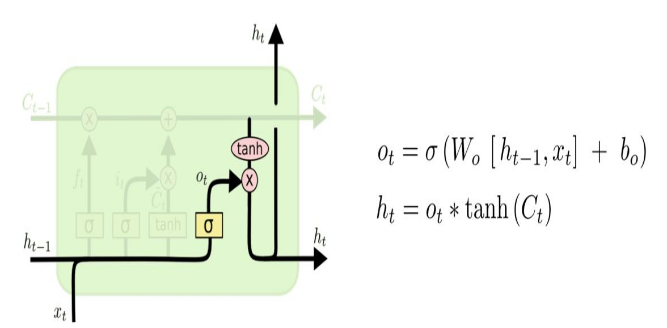

In [ ]:
serie_size = X_train.shape[1]  #12
n_features = X_train.shape[2]  #1

epochs = 20
batch = 128  #mini-batch size
lr = 0.0001

#Sequential 모델(각 layer를 순차적으로 쌓는 간단한 신경망 구조) 생성
lstm_model = Sequential()

#LSTM layer 1: 10 units.
#return_sequences=True: 시퀀스 출력을 반환
lstm_model.add(L.LSTM(10, input_shape=(serie_size, n_features), return_sequences=True))
#LSTM layer 2: 6 units.
lstm_model.add(L.LSTM(6, activation='relu', return_sequences=True))
#LSTM layer 3: 1 unit
lstm_model.add(L.LSTM(1, activation='relu'))

#Dense layer 1
#kernel_initializer='glorot_normal': Glorot 초기화로 가중치 초기화. 초기 가중치는 평균 0, 분산 일정.
lstm_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
#Dense layer 2
lstm_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
#Dense layer 3: 출력값 예측을 위한 선형 층
lstm_model.add(L.Dense(1))

#모델 구조 출력. 각 층의 구성 및 매개변수 수를 표시.
lstm_model.summary()

adam = optimizers.Adam(lr)
lstm_model.compile(loss='mse', optimizer=adam)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 10)            480       
                                                                 
 lstm_1 (LSTM)               (None, 12, 6)             408       
                                                                 
 lstm_2 (LSTM)               (None, 1)                 32        
                                                                 
 dense (Dense)               (None, 10)                20        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1061 (4.14 KB)
Trainable params: 1061 (4.1

In [ ]:
lstm_history = lstm_model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid),
                              batch_size=batch, epochs=epochs, verbose=2)
#verbose=2: 각 epoch의 시작과 끝에 loss 값 등의 간단한 로그 출력. 진행 표시 막대는 표시되지 않음.

Epoch 1/20
1566/1566 - 33s - loss: 1.4853 - val_loss: 1.3374 - 33s/epoch - 21ms/step
Epoch 2/20
1566/1566 - 29s - loss: 1.3638 - val_loss: 1.2778 - 29s/epoch - 19ms/step
Epoch 3/20
1566/1566 - 28s - loss: 1.2879 - val_loss: 1.2232 - 28s/epoch - 18ms/step
Epoch 4/20
1566/1566 - 27s - loss: 1.2365 - val_loss: 1.2004 - 27s/epoch - 18ms/step
Epoch 5/20
1566/1566 - 27s - loss: 1.2115 - val_loss: 1.1956 - 27s/epoch - 17ms/step
Epoch 6/20
1566/1566 - 30s - loss: 1.1976 - val_loss: 1.1785 - 30s/epoch - 19ms/step
Epoch 7/20
1566/1566 - 32s - loss: 1.1896 - val_loss: 1.1742 - 32s/epoch - 21ms/step
Epoch 8/20
1566/1566 - 31s - loss: 1.1850 - val_loss: 1.1722 - 31s/epoch - 19ms/step
Epoch 9/20
1566/1566 - 29s - loss: 1.1819 - val_loss: 1.1654 - 29s/epoch - 19ms/step
Epoch 10/20
1566/1566 - 28s - loss: 1.1796 - val_loss: 1.1635 - 28s/epoch - 18ms/step
Epoch 11/20
1566/1566 - 28s - loss: 1.1771 - val_loss: 1.1634 - 28s/epoch - 18ms/step
Epoch 12/20
1566/1566 - 28s - loss: 1.1751 - val_loss: 1.1608 -

#Autoencoder

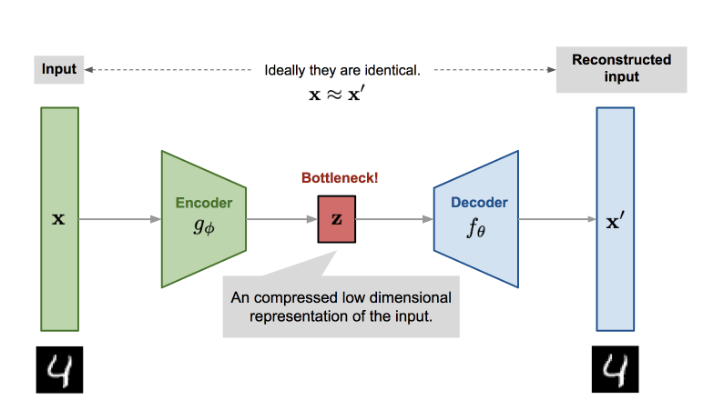

- input layer, hidden layer, output layer로 구성됨
- 일반적으로 input unit보다 훨씬 낮은 차원의 hidden unit을 가지므로 주로 차원 축소 목적으로 사용됨.
- 내부 표현 크기 제한, 입력 잡음 추가 등 여러 방법의 제약을 통해 autoencoder가 단순히 입력을 바로 출력으로 복사하지 못하도록 막고, 데이터를 효율적으로 재표현하는 방법을 학습하도록 제어한다.
- encoder: recognition network. 입력을 내부 표현으로 변환
- decoder: generative network. 내부 표현을 출력으로 변환.
- reconstruction loss: 입력과 재구성된 출력과의 차이로 계산


#LSTM Autoencoder

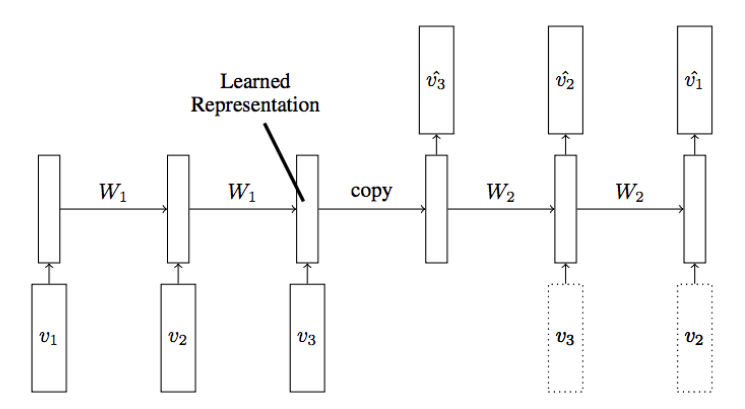

- 입력 시퀀스가 순차적으로 들어오고, 마지막 입력 시퀀스가 들어온 후, decoder는 입력 시퀀스를 재생성하거나 목표 시퀀스에 대한 예측을 출력한다.

https://velog.io/@jaehyeong/Autoencoder%EC%99%80-LSTM-Autoencoder

In [ ]:
#Sequential 모델 생성
encoder_decoder = Sequential()

#encoder 부분
#입력 시퀀스의 특징을 추출
encoder_decoder.add(L.LSTM(serie_size, activation='relu', input_shape=(serie_size, n_features), return_sequences=True))
#더 낮은 차원의 특징을 추출
encoder_decoder.add(L.LSTM(6, activation='relu', return_sequences=True))
#최종 특징을 추출
encoder_decoder.add(L.LSTM(1, activation='relu'))

#decoder 부분
#RepeatVector layer: 디코더의 입력 시퀀스를 생성하기 위해 인코더의 마지막 출력을 반복
encoder_decoder.add(L.RepeatVector(serie_size))
#시퀀스를 생성
encoder_decoder.add(L.LSTM(serie_size, activation='relu', return_sequences=True))
#시퀀스를 생성
encoder_decoder.add(L.LSTM(6, activation='relu', return_sequences=True))
#시퀀스 출력을 생성하는 마지막 층
#TimeDistributed: 각 시간 단계에 대한 독립적인 Dense 층. 이 층은 각 시간 단계에서 1개의 값을 출력
encoder_decoder.add(L.TimeDistributed(L.Dense(1)))
encoder_decoder.summary()

adam = optimizers.Adam(lr)
encoder_decoder.compile(loss='mse', optimizer=adam)

NameError: ignored

In [ ]:
encoder_decoder_history = encoder_decoder.fit(X_train, X_train, batch_size=batch,
                                              epochs=epochs, verbose=2)

좋은 autoencoder는 좋은 encoder를 의미한다.

In [ ]:
#Model 클래스를 사용하여 새로운 모델을 정의.
#encoder_decoder 모델의 일부를 추출하고, 이 추출된 모델을 rpt_vecotr_layer와 time_dist_layer로 저장.
#inputs=encoder_decoder.inputs: encoder_decoder 모델과 동일한 입력을 사용
#outputs=encoder_decoder.layers[3].output: encoder_decoder 모델의 특정 층의 출력을 rpt_vector_layer로 설정. 네 번째 층을 의미
#outputs=encoder_decoder.layers[5].output: 여섯 번째 층
rpt_vector_layer = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[3].output)
time_dist_layer = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[5].output)

#encoder_decoder 모델의 모든 layer를 출력
encoder_decoder.layers

encoder_decoder 모델에서 특정 층의 출력을 추출하여 새로운 모델인 rpt_vecotr_layer와 time_dist_layer로 저장 -> 추출된 모델을 사용하여 원하는 출력을 생성하거나 다른 작업에 활용 가능.

- rpt_vecotr_layer 모델 사용 -> 인코더의 출력을 얻을 수 있음
- time_dist_layer 모델 사용 -> 디코더의 시간 분포 출력을 얻을 수 있음

## RepeatVector layer

RepeatVector layer repeats its input n times.
Why we use this layer?: the last layer from the encoder which has one neuron (encoder_decoder.add(L.LSTM(1, activation='relu'))) don't return sequences. -> the last layer from the encoder doesn't output a sequenced data. -> We can't just add another LSTM layer after the last layer from the encoder. -> We need a way to turn this output into a sequence of the same time-steps of the model input.

In [ ]:
rpt_vector_layer_output = rpt_vector_layer.predict(X_train[:1])
print('Repeat vector output shape', rpt_vector_layer_output.shape)
print('Repeat vector output sample')
print(rpt_vector_layer_output[0])

=> model input과 같은 shape

## TimeDistributed layer

Using a 'TimeDistributed layer' wrapping a 'Dense layer', we will have the same weights for each outputted time-step.

In [ ]:
time_dist_layer_output = time_dist_layer.predict(X_train[:1])
print('Time distributed output shape', time_dist_layer_output.shape)
print('Time distributed output sample')
print(time_dist_layer_output[0])

## Defining the encoding model

We want to encode the whole series into a single value. 
-> So we need the output from the layer with a single neuron, which is the third LSTM layer.
    encoder_decoder.add(L.LSTM(1, activation='relu'))

In [ ]:
encoder = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[2].output)


#train, validation time-series로 encode하자.
train_encoded = encoder.predict(X_train)
validation_encoded = encoder.predict(X_valid)
print('Encoded time-series shape', train_encoded.shape)
print('Encoded time-series sample', train_encoded[0])

In [ ]:
#